In [377]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


In [378]:
# load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [380]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [381]:
for col in df.columns:
    print(f"Unique values in column '{col}': {df[col].unique()}")

Unique values in column 'alcohol': [13.73 14.13 12.16 13.07 13.16 11.76 12.08 13.75 13.78 12.58 13.32 13.88
 11.65 13.58 14.21 12.37 13.72 13.36 13.41 13.11 12.29 11.45 12.42 14.38
 14.39 13.3  13.52 11.84 12.25 12.22 12.   12.51 11.82 12.17 14.34 12.77
 13.49 12.52 13.71 13.5  11.81 13.83 12.84 11.96 12.72 12.43 13.48 11.62
 13.68 12.45 11.79 13.82 13.05 13.9  13.45 13.2  12.93 11.03 12.47 13.4
 12.7  12.21 13.63 13.62 14.23 12.79 13.17 12.96 13.86 12.6  12.07 13.24
 12.87 12.33 13.87 13.28 13.56 12.53 13.03 12.04 11.61 14.1  11.46 13.74
 12.34 13.29 14.06 13.27 13.64 13.94 14.75 12.82 13.23 13.51 12.86 13.67
 12.64 12.85 13.39 11.64 12.36 14.22 14.12 14.19 13.76 13.08 11.41 14.37
 12.69 12.2  13.69 14.3  11.66 14.83 12.99 13.84 12.67 13.77 11.87 14.02
 12.88 13.34 11.56 12.81 14.16 14.2 ]
Unique values in column 'malic_acid': [1.5  4.1  1.61 2.36 2.68 2.08 1.73 2.76 1.29 3.24 1.33 1.89 1.67 2.58
 4.04 1.21 1.43 0.94 2.56 3.84 1.9  2.83 2.4  2.55 1.41 3.59 1.83 1.87
 1.72 3.17 2.89 4.

In [382]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


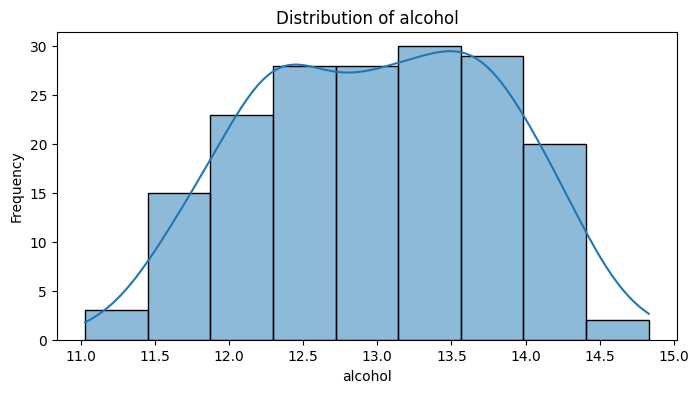

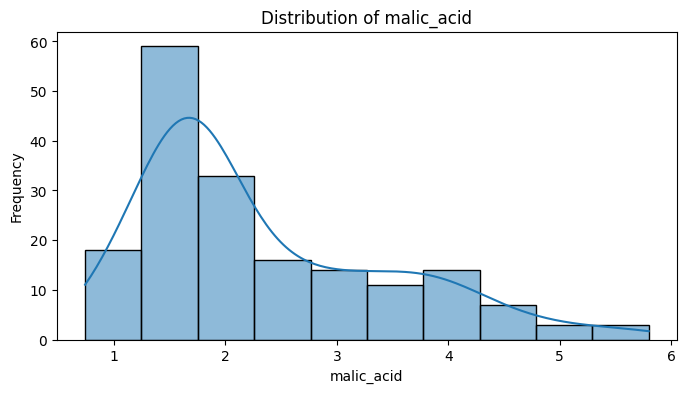

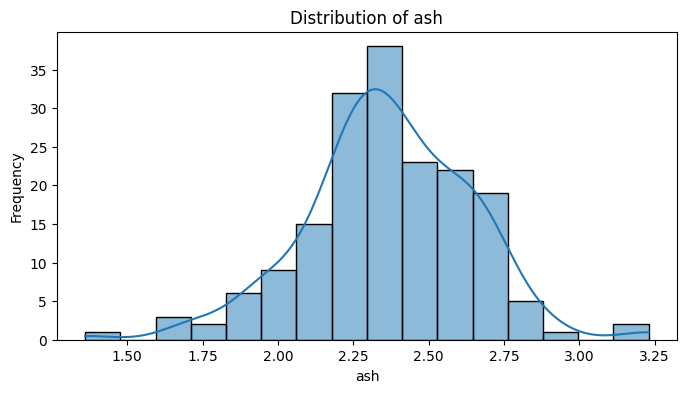

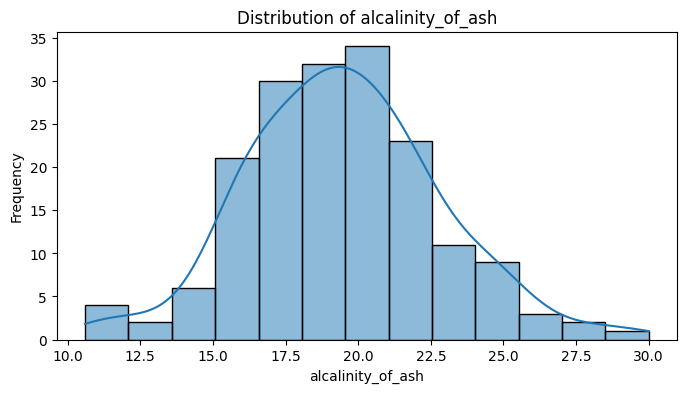

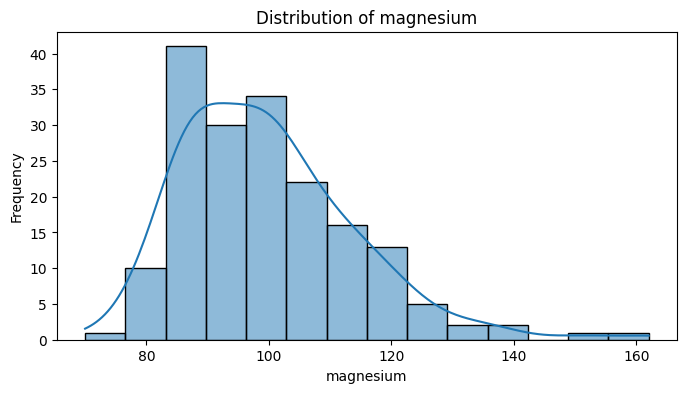

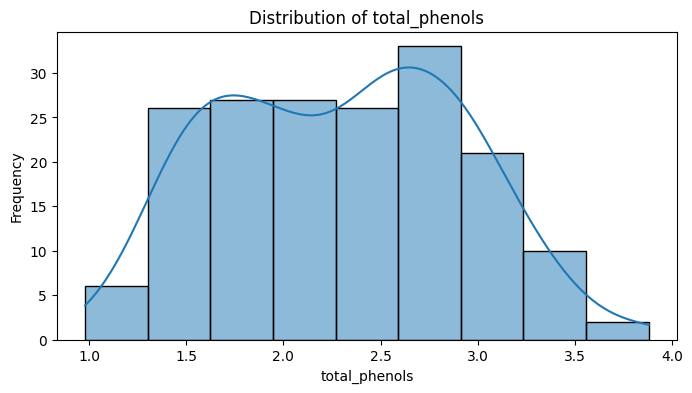

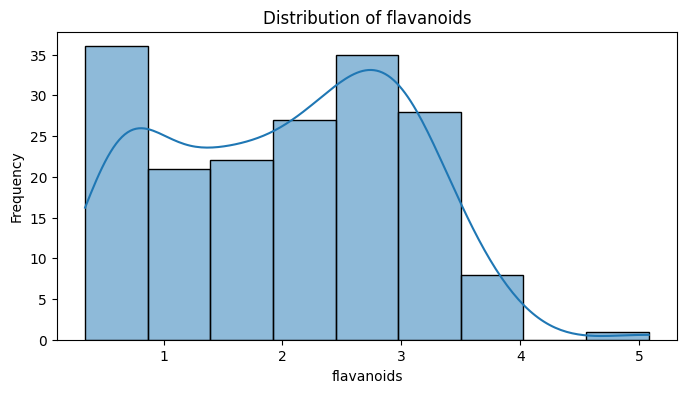

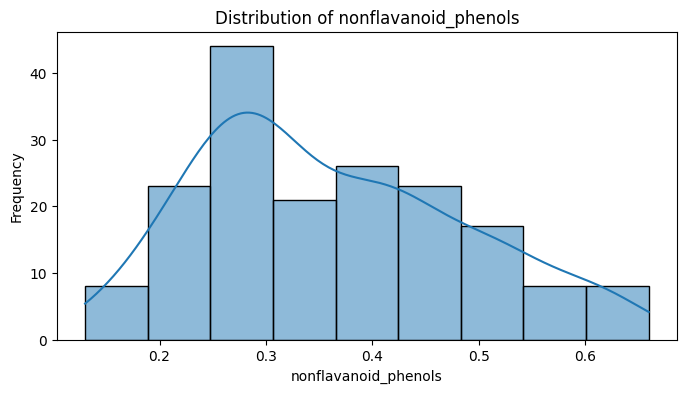

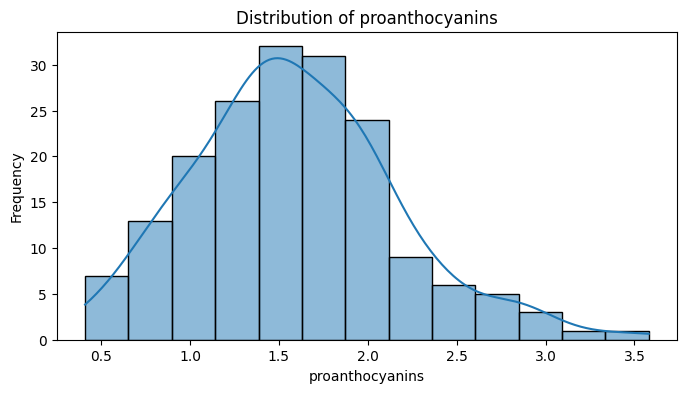

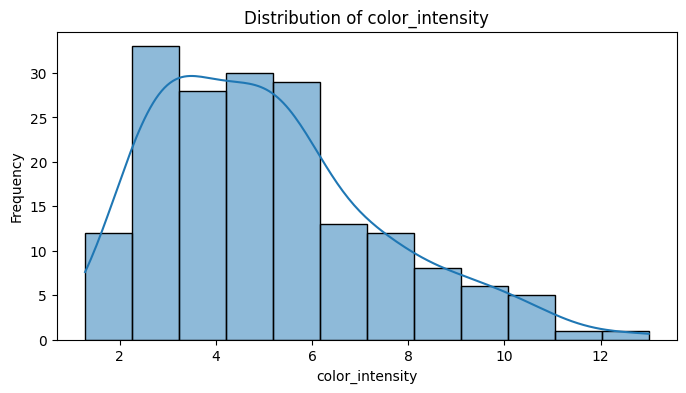

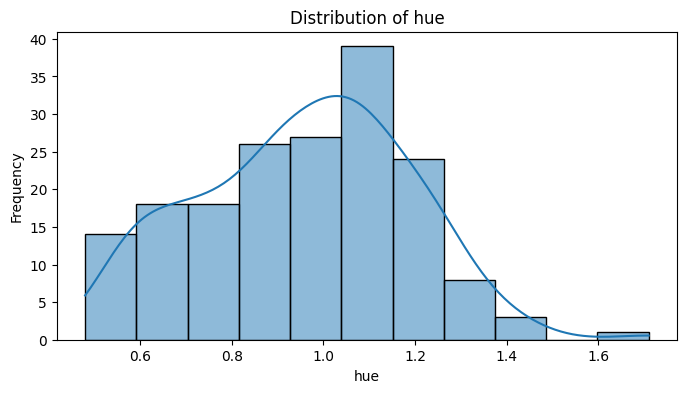

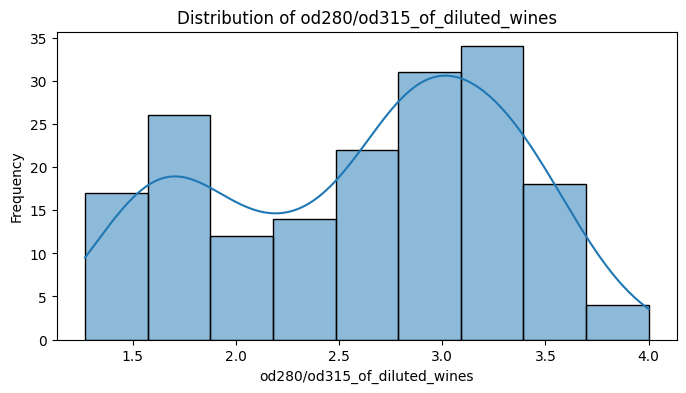

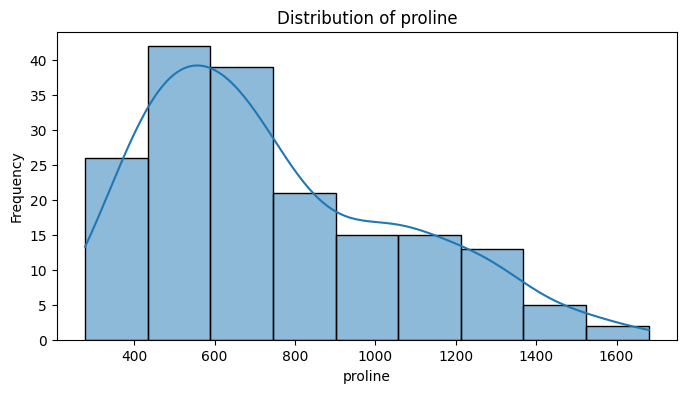

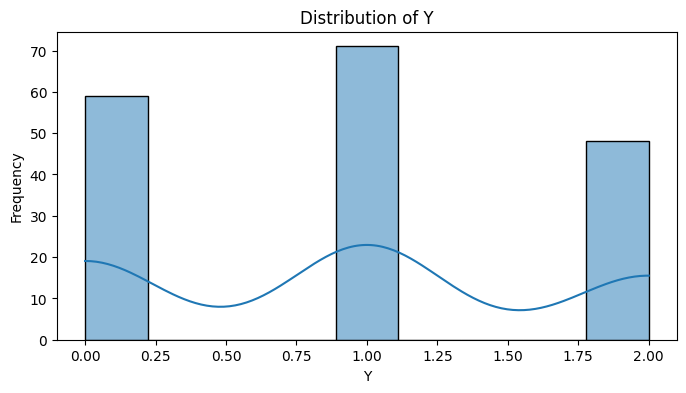

In [383]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for histograms
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

* alcohol: Distribusinya terlihat mendekati normal, dengan sebagian besar nilai berada di sekitar 12-14.
* malic_acid: Distribusinya sangat miring ke kanan (positively skewed), dengan banyak nilai rendah dan beberapa nilai yang sangat tinggi.
* ash: Distribusinya terlihat agak simetris, terpusat di sekitar 2.3-2.4.
* alcalinity_of_ash: Distribusinya terlihat agak miring ke kanan, dengan beberapa nilai yang lebih tinggi.
* magnesium: Distribusinya juga miring ke kanan, dengan sebagian besar nilai di bawah 120 dan beberapa outlier di atasnya.
* total_phenols: Distribusinya terlihat agak bimodal atau memiliki dua puncak, menunjukkan kemungkinan adanya dua kelompok berbeda dalam data terkait fitur ini.
* flavanoids: Distribusinya juga terlihat bimodal, mirip dengan total_phenols.
* nonflavanoid_phenols: Distribusinya terlihat miring ke kanan, dengan sebagian besar nilai di bawah 0.5.
* proanthocyanins: Distribusinya terlihat agak simetris, terpusat di sekitar 1.5-1.6.
* color_intensity: Distribusinya sangat miring ke kanan, dengan banyak nilai rendah dan beberapa nilai yang sangat tinggi.
* hue: Distribusinya terlihat mendekati normal, terpusat di sekitar 0.9-1.0.
* diluted_wines: Distribusinya terlihat bimodal atau memiliki dua puncak yang jelas, menunjukkan adanya dua kelompok berbeda dalam data.
* proline: Distribusinya sangat miring ke kanan, dengan banyak nilai rendah dan beberapa nilai yang sangat tinggi.
* Y: Ini adalah kolom target yang menunjukkan kelas anggur (0, 1, 2). Histogram menunjukkan jumlah sampel untuk setiap kelas. Terlihat bahwa jumlah sampel untuk setiap kelas tidak terlalu jauh berbeda, meskipun mungkin ada sedikit ketidakseimbangan.



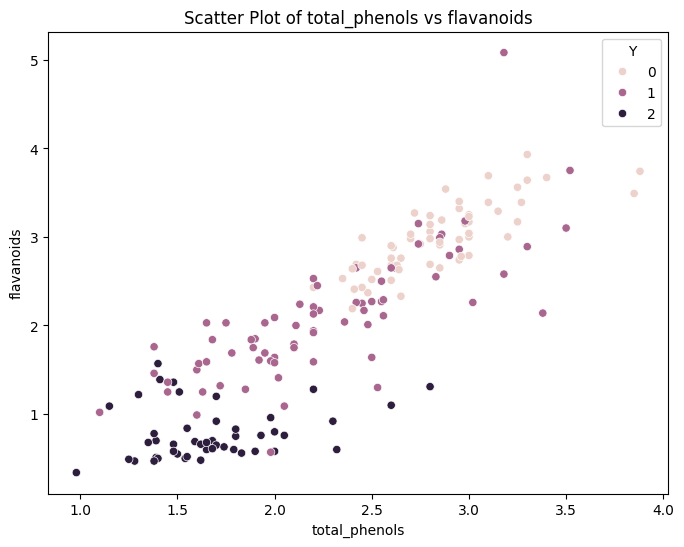

In [384]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='total_phenols', y='flavanoids', hue='Y')
plt.title('Scatter Plot of total_phenols vs flavanoids')
plt.xlabel('total_phenols')
plt.ylabel('flavanoids')
plt.show()

Dari scatter plot ini, terlihat ada pemisahan yang cukup jelas antara ketiga kelas (Y=0, Y=1, dan Y=2) berdasarkan kombinasi nilai total_phenols dan flavanoids:

* Kelas 0 (Biru): Titik-titik data untuk kelas ini cenderung terkumpul di area dengan nilai total_phenols dan flavanoids yang tinggi.
* Kelas 2 (Hijau): Titik-titik data untuk kelas ini terkumpul di area dengan nilai total_phenols yang lebih rendah dan nilai flavanoids yang paling rendah dibandingkan kelas lainnya.
* Kelas 1 (Oranye): Titik-titik data untuk kelas ini berada di antara Kelas 0 dan Kelas 2, dengan nilai total_phenols dan flavanoids yang sedang. Ada sedikit tumpang tindih dengan Kelas 0 dan Kelas 2, tetapi secara umum membentuk kelompok yang terpisah.

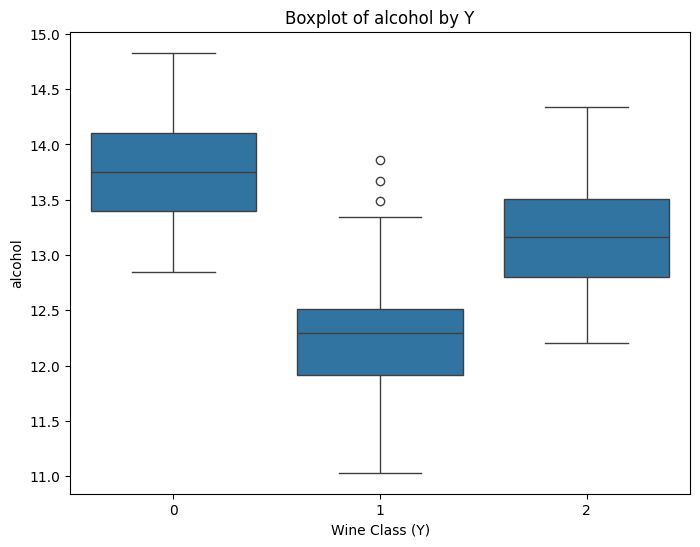

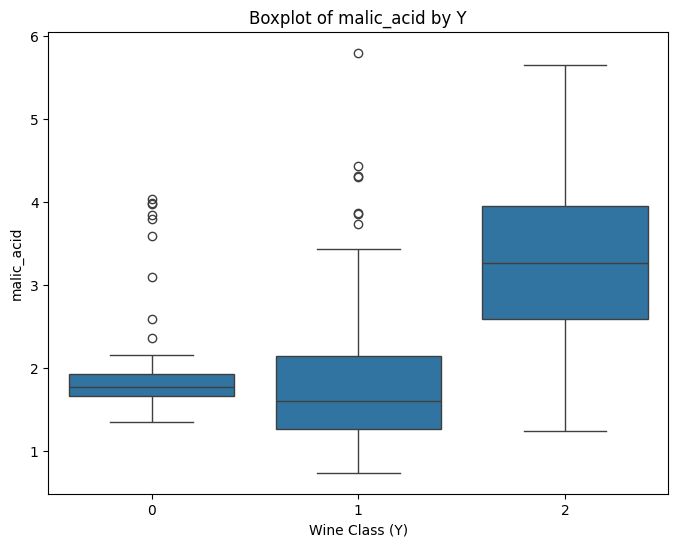

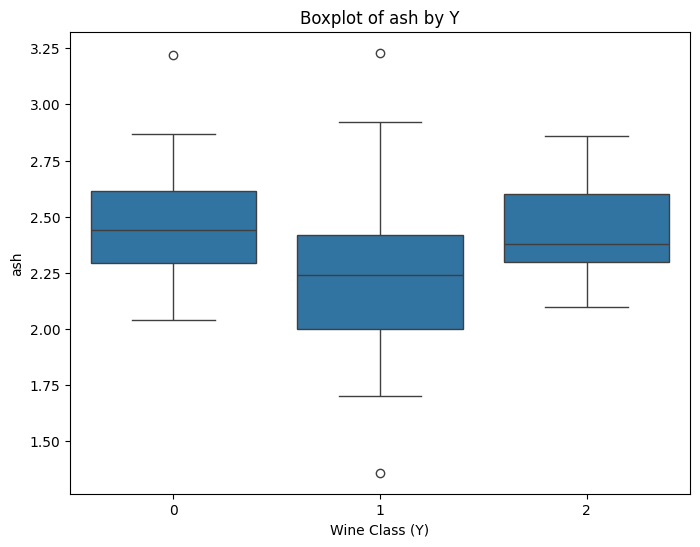

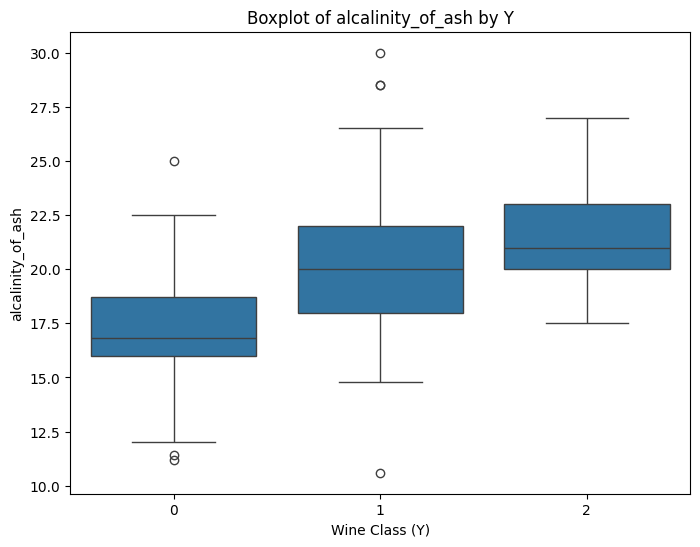

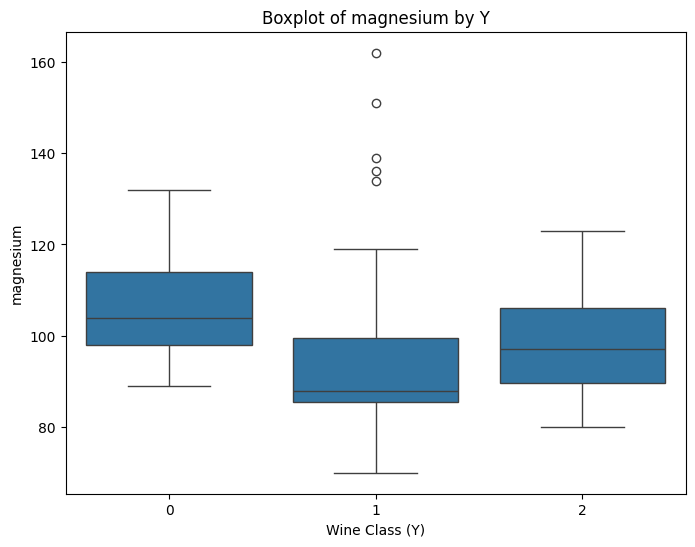

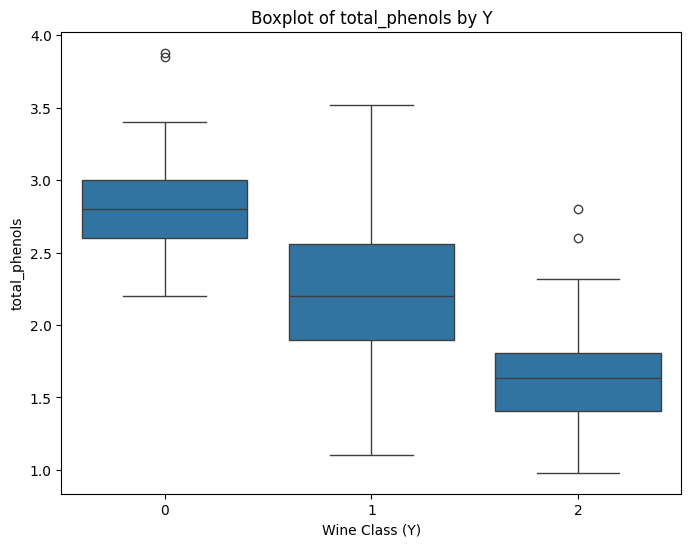

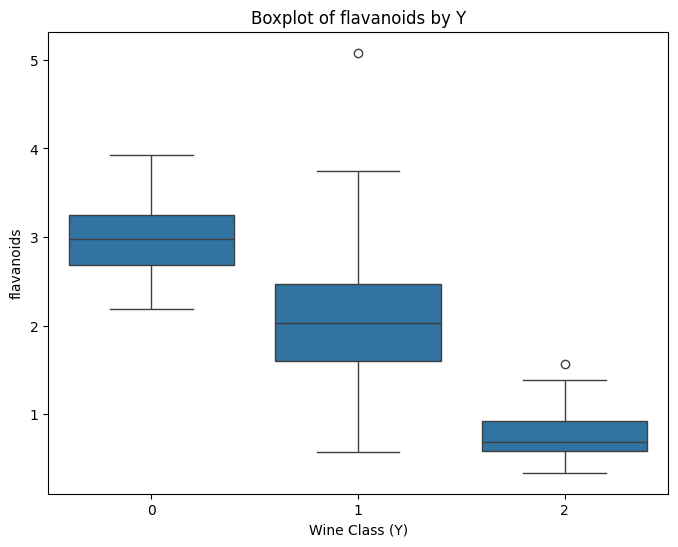

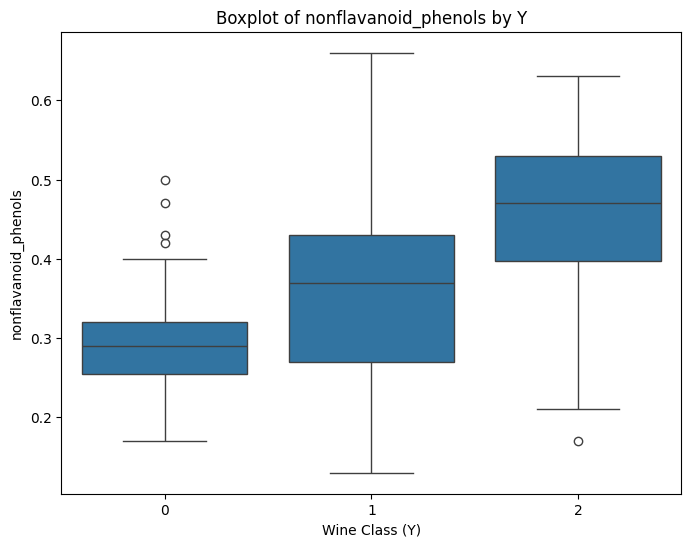

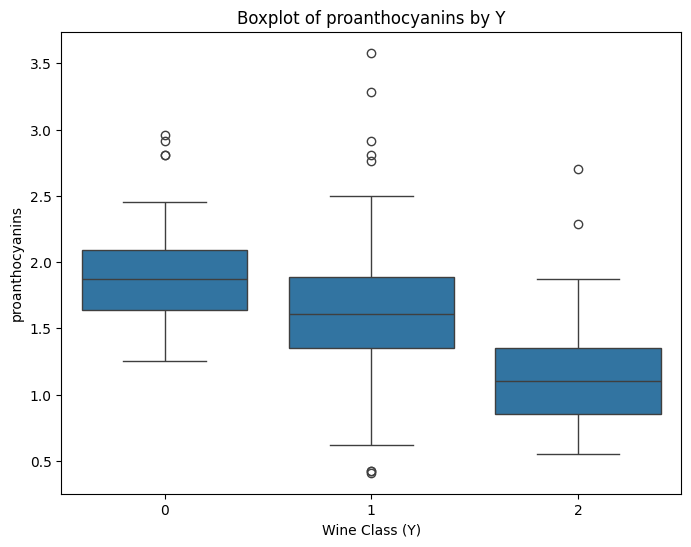

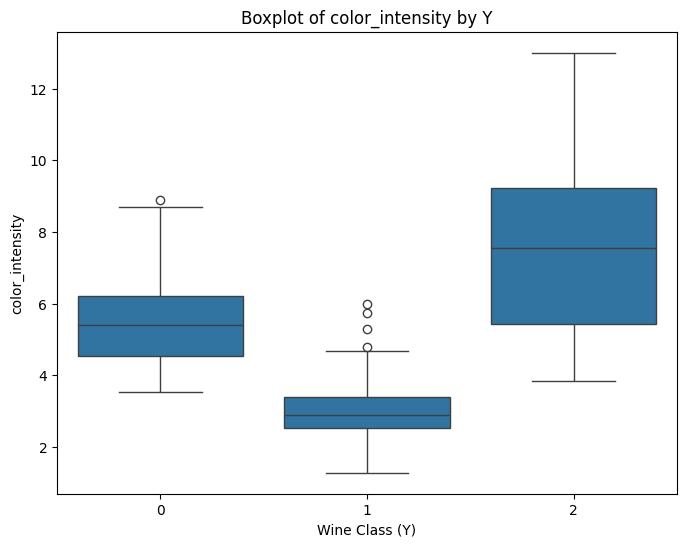

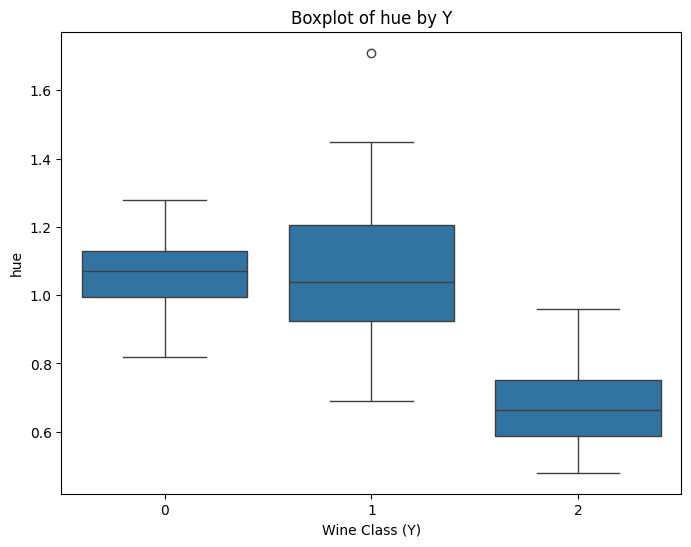

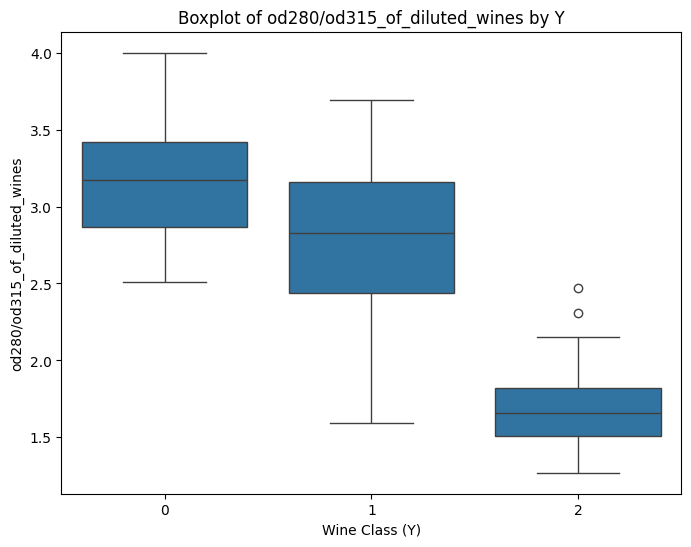

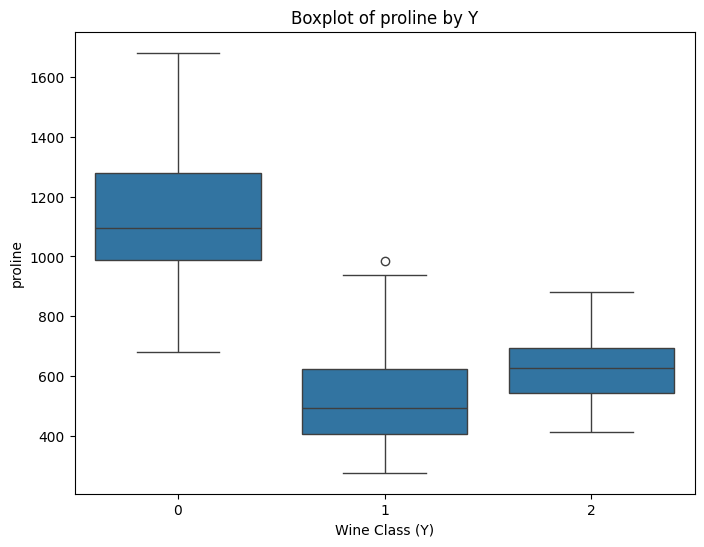

In [385]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('Y') # Remove the target column from numerical features for boxplots

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='Y', y=col)
    plt.title(f'Boxplot of {col} by Y')
    plt.xlabel('Wine Class (Y)')
    plt.ylabel(col)
    plt.show()

* alcohol: Kelas 0 cenderung memiliki kadar alkohol yang lebih tinggi dibandingkan Kelas 1 dan 2. Ada tumpang tindih, tetapi mediannya berbeda.
* malic_acid: Kelas 2 memiliki nilai malic_acid yang secara signifikan lebih tinggi dibandingkan Kelas 0 dan 1. Kelas 0 dan 1 memiliki distribusi malic_acid yang lebih rendah dan serupa.
* ash: Distribusi ash cukup mirip di ketiga kelas, meskipun ada sedikit perbedaan median.
* alcalinity_of_ash: Kelas 1 dan 2 cenderung memiliki alcalinity_of_ash yang lebih tinggi daripada Kelas 0.
* magnesium: Kelas 0 memiliki median magnesium yang sedikit lebih tinggi, dan ada beberapa outlier dengan nilai magnesium yang sangat tinggi di Kelas 0 dan 1.
* total_phenols: Kelas 0 memiliki nilai total_phenols yang jauh lebih tinggi dibandingkan Kelas 1 dan 2. Kelas 2 memiliki nilai terendah.
* flavanoids: Mirip dengan total_phenols, Kelas 0 memiliki nilai flavanoids yang paling tinggi, diikuti oleh Kelas 1, dan Kelas 2 memiliki nilai terendah. Fitur ini menunjukkan pemisahan yang sangat jelas antar kelas.
* nonflavanoid_phenols: Distribusi fitur ini cukup serupa di ketiga kelas, meskipun ada sedikit perbedaan median.
* proanthocyanins: Kelas 0 cenderung memiliki nilai proanthocyanins yang lebih tinggi dibandingkan Kelas 1 dan 2.
* color_intensity: Kelas 2 memiliki color_intensity yang jauh lebih tinggi, dengan median dan sebaran yang berbeda dari Kelas 0 dan 1. Kelas 0 dan 1 memiliki rentang nilai yang tumpang tindih.
* hue: Kelas 0 dan 1 cenderung memiliki nilai hue yang lebih tinggi dibandingkan Kelas 2.
* diluted_wines: Kelas 0 memiliki nilai diluted_wines yang paling tinggi, diikuti oleh Kelas 1, dan Kelas 2 memiliki nilai terendah. Fitur ini juga menunjukkan pemisahan yang cukup baik antar kelas.
* proline: Kelas 0 memiliki nilai proline yang jauh lebih tinggi dibandingkan Kelas 1 dan 2. Kelas 2 memiliki nilai terendah. Fitur ini menunjukkan pemisahan yang sangat jelas antar kelas.

## Generate Rules with PRISM

In [386]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(142), 'Y')


........................................................................
Target: 1
........................................................................
color_intensity = Low AND alcohol = Low
   Support:  the target has value: '1' for 100.000% of the 38 rows matching the rule 
   Coverage: the rule matches: 38 out of 56 rows for target value: '1'. This is:
      67.857% of total rows for target value: '1'
      26.761% of total rows in data

........................................................................
Target: 0
........................................................................
proline = High AND alcohol = High
   Support:  the target has value: '0' for 100.000% of the 31 rows matching the rule 
   Coverage: the rule matches: 31 out of 49 rows for target value: '0'. This is:
      63.265% of total rows for target value: '0'
      21.831% of total rows in data
proline = High AND alcohol = Med
   Support:  The target has value: '0' for 84.615% of the 11 remaining ro

Untuk setiap aturan, kita akan melihat:

* Arti Aturan: Kombinasi fitur dan nilai apa yang mengarah pada aturan tersebut.
* Kelas Target: Kelas anggur (Y) mana yang diprediksi oleh aturan ini.
* Kekuatan Aturan (Support dan Coverage): Seberapa sering aturan ini muncul dalam data training (Support) dan seberapa banyak data training dari kelas target yang berhasil dicakup oleh aturan ini (Coverage). Kita juga bisa melihat rentang nilai asli untuk bin yang disebutkan dalam aturan menggunakan informasi dari bin_ranges_df di cell tQMDfMVczXa2.
Berikut adalah interpretasi untuk setiap aturan yang dihasilkan berdasarkan data training yang diperbarui:

1. Target: 1

* Aturan: color_intensity = Low AND alcohol = Low
* Arti Aturan: Jika intensitas warna anggur rendah DAN kadar alkohol rendah.
* Kelas Target: Kelas 1.

Kekuatan Aturan:
* Support: the target has value: '1' for 100.000% of the 38 rows matching the rule. Ini berarti semua 38 baris di data training yang cocok dengan aturan ini adalah milik Kelas 1.
* Coverage: the rule matches: 38 out of 56 rows for target value: '1'. This is: 67.857% of total rows for target value: '1', dan 26.761% of total rows in data. Aturan ini mencakup 67.857% dari total baris Kelas 1 di data training (56 baris).
* Interpretasi Tambahan: Berdasarkan bin_ranges_df, "Low" untuk color_intensity berada dalam rentang [1.28, 3.80], dan "Low" untuk alcohol berada dalam rentang [11.03, 12.67]. Jadi, aturan ini berarti "Jika intensitas warna anggur antara 1.28 dan 3.80 DAN kadar alkohol antara 11.03 dan 12.67, maka cenderung termasuk dalam Kelas 1."

2. Target: 0

* Aturan 1: proline = High AND alcohol = High
* Arti Aturan: Jika nilai proline tinggi DAN kadar alcohol tinggi.
* Kelas Target: Kelas 0.

Kekuatan Aturan:
* Support: the target has value: '0' for 100.000% of the 31 rows matching the rule. Semua 31 baris di data training yang cocok adalah Kelas 0.
* Coverage: the rule matches: 31 out of 49 rows for target value: '0'. This is: 63.265% of total rows for target value: '0', dan 21.831% of total rows in data. Aturan ini mencakup 63.265% dari total baris Kelas 0 di data training (49 baris).
* Interpretasi Tambahan: Berdasarkan bin_ranges_df, "High" untuk proline adalah [840.00, 1547.00], dan "High" untuk alcohol adalah [13.50, 14.83]. Jadi, "Jika proline antara 840.00 dan 1547.00 DAN alcohol antara 13.50 dan 14.83, maka cenderung Kelas 0."

* Aturan 2: proline = High AND alcohol = Med
* Arti Aturan: Jika nilai proline tinggi DAN kadar alcohol sedang.
* Kelas Target: Kelas 0.

Kekuatan Aturan:
* Support: The target has value: '0' for 84.615% of the 11 remaining rows matching the rule. Dari 11 baris yang tersisa (tidak dicakup oleh aturan sebelumnya) yang cocok dengan aturan ini, 84.615% adalah Kelas 0.
* Coverage: The rule matches: 11 out of 18 rows remaining for target value: '0'. This is: 61.111% of remaining rows for target value: '0', 22.449% of total rows for target value: '0', dan 7.746% of total rows in data. Aturan ini mencakup 61.111% dari sisa baris Kelas 0 di data training (18 baris) setelah aturan pertama diterapkan.
* Interpretasi Tambahan: Berdasarkan bin_ranges_df, "High" untuk proline adalah [840.00, 1547.00], dan "Med" untuk alcohol adalah [12.67, 13.50]. Jadi, "Jika proline antara 840.00 dan 1547.00 DAN alcohol antara 12.67 dan 13.50, maka cenderung Kelas 0." Aturan ini menangkap sisa kasus Kelas 0 yang tidak tercakup oleh aturan pertama untuk Kelas 0.
* Target: 2

* Aturan 1: flavanoids = Low AND color_intensity = Med
* Arti Aturan: Jika nilai flavanoids rendah DAN intensitas warna sedang.
* Kelas Target: Kelas 2.

Kekuatan Aturan:
* Support: the target has value: '2' for 100.000% of the 11 rows matching the rule. Semua 11 baris yang cocok adalah Kelas 2.
* Coverage: the rule matches: 11 out of 37 rows for target value: '2'. This is: 29.730% of total rows for target value: '2', dan 7.746% of total rows in data. Aturan ini mencakup 29.730% dari total baris Kelas 2 di data training (37 baris).
* Interpretasi Tambahan: Berdasarkan bin_ranges_df, "Low" untuk flavanoids adalah [0.34, 1.50], dan "Med" untuk color_intensity adalah [3.80, 5.58]. Jadi, "Jika flavanoids antara 0.34 dan 1.50 DAN color_intensity antara 3.80 dan 5.58, maka cenderung Kelas 2."

* Aturan 2: flavanoids = Low AND color_intensity = High AND hue = Low
* Arti Aturan: Jika nilai flavanoids rendah DAN intensitas warna tinggi DAN hue rendah.
* Kelas Target: Kelas 2.

Kekuatan Aturan:
* Support: The target has value: '2' for 100.000% of the 24 remaining rows matching the rule. Semua 24 baris yang tersisa yang cocok dengan aturan ini adalah Kelas 2.
* Coverage: The rule matches: 24 out of 26 rows remaining for target value: '2'. This is: 92.308% of remaining rows for target value: '2', 64.865% of total rows for target value: '2', dan 16.901% of total rows in data. Aturan ini mencakup 92.308% dari sisa baris Kelas 2 di data training (26 baris).
* Interpretasi Tambahan: Berdasarkan bin_ranges_df, "Low" untuk flavanoids adalah [0.34, 1.50], "High" untuk color_intensity adalah [5.58, 13.00], dan "Low" untuk hue adalah [0.48, 0.88]. Jadi, "Jika flavanoids antara 0.34 dan 1.50 DAN color_intensity antara 5.58 dan 13.00 DAN hue antara 0.48 dan 0.88, maka cenderung Kelas 2." Aturan ini menangkap sebagian besar sisa kasus Kelas 2.

## Bin Ranges Result

In [387]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.03,12.67,65
1,alcohol,1,12.67,13.50,56
2,alcohol,2,13.50,14.83,57
3,malic_acid,0,0.74,1.68,60
4,malic_acid,1,1.68,2.55,58
5,malic_acid,2,2.55,5.80,60
6,ash,0,1.36,2.28,59
7,ash,1,2.28,2.48,58
8,ash,2,2.48,3.22,60
9,alcalinity_of_ash,0,10.60,18.00,53


## Test on Y Pred

In [388]:
# we use the rest of our data for testing, in this case is 50 rows
y_pred = prism.predict(df.tail(35).drop(columns=['Y']))
f1_score(df.tail(35)['Y'], y_pred, average=None)

array([0.94736842, 0.96551724, 1.        ])

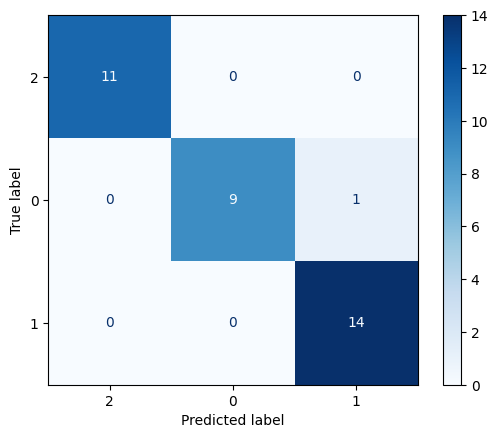

In [389]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(35)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [390]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(35)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        11

    accuracy                           0.97        35
   macro avg       0.98      0.97      0.97        35
weighted avg       0.97      0.97      0.97        35



**Kelas Mana yang Diprediksi Terbaik?**

Berdasarkan F1-score dan laporan klasifikasi:

* Kelas 2 memiliki F1-score 1.00. Precision dan recall-nya juga 1.00. Ini berarti semua prediksi untuk Kelas 2 adalah benar, dan semua instance Kelas 2 di data uji berhasil diprediksi dengan benar. Kelas 2 adalah kelas yang diprediksi terbaik.
* Kelas 1 memiliki F1-score 0.97 (atau 0.9655 jika dilihat dari output F1 score mentah). Precision 0.93 dan recall 1.00. Ini menunjukkan bahwa semua instance Kelas 1 berhasil diprediksi (recall 100%), tetapi ada beberapa prediksi untuk Kelas 1 yang sebenarnya bukan Kelas 1 (precision 93%).
* Kelas 0 memiliki F1-score 0.95 (atau 0.9473 jika dilihat dari output F1 score mentah). Precision 1.00 dan recall 0.90. Ini menunjukkan bahwa semua prediksi untuk Kelas 0 adalah benar (precision 100%), tetapi ada beberapa instance Kelas 0 yang tidak berhasil diprediksi sebagai Kelas 0 (recall 90%).

Meskipun semua kelas memiliki performa yang sangat baik (F1-score di atas 0.94), Kelas 2 menunjukkan performa sempurna di data uji ini.

**Apakah Ada Kesalahan Klasifikasi (Misklasifikasi)?**

Ya, ada beberapa kesalahan klasifikasi, meskipun jumlahnya sangat sedikit, seperti yang terlihat pada confusion matrix dan laporan klasifikasi:

* Confusion Matrix: Melihat matriks kebingungan (cell De5_jzjYzp0r), angka-angka di luar diagonal utama menunjukkan misklasifikasi. Terlihat ada angka 1 di baris 0, kolom 1. Ini berarti ada 1 instance aktual dari Kelas 0 yang salah diprediksi sebagai Kelas 1.

* Laporan Klasifikasi:
1. Recall untuk Kelas 0 adalah 0.90, yang berarti 10% dari instance Kelas 0 tidak diklasifikasikan dengan benar sebagai Kelas 0. Berdasarkan confusion matrix, 1 instance Kelas 0 salah diklasifikasikan sebagai Kelas 1.
2. Precision untuk Kelas 1 adalah 0.93, yang berarti ada 7% prediksi sebagai Kelas 1 yang sebenarnya bukan Kelas 1. Berdasarkan confusion matrix, 1 prediksi sebagai Kelas 1 sebenarnya adalah Kelas 0.

Jadi, terdapat 1 misklasifikasi: satu anggur yang sebenarnya termasuk Kelas 0 salah diklasifikasikan sebagai Kelas 1.

Secara keseluruhan, model PRISM menunjukkan performa yang sangat baik pada data uji ini, dengan hanya satu instance yang salah diklasifikasikan.

In [391]:
# Create new data points for the wine dataset
# You can change these values to test different scenarios
new_data = {
 'alcohol': [14.0, 14.00],
 'malic_acid': [2.0, 2.0],
 'ash': [2.3, 2.2],
 'alcalinity_of_ash': [19.0, 11.0],
 'magnesium': [95.0, 95.0],
 'total_phenols': [2.2, 2.5],
 'flavanoids': [0.14, 0.5],
 'nonflavanoid_phenols': [0.14, 0.5],
 'proanthocyanins': [1.6, 1.5],
 'color_intensity': [7.0, 6.0],
 'hue': [0.7, 0.6],
 'od280/od315_of_diluted_wines': [3.2, 3.0],
 'proline': [550.0, 1400.0]
}


new_wine_df = pd.DataFrame(new_data)

# Predict on the new Wine data using the prism model trained on Wine data
wine_prediction = prism.predict(new_wine_df)
# Assign predictions to a new column in the DataFrame
new_wine_df['Predicted Class'] = wine_prediction

# Display the new data and prediction
print("New Wine Data Points:")
display(new_wine_df)

New Wine Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,0


### Sampel 0 = Class 1

Mengapa aturan ini cocok untuk sampel ini:

Proline 550 → bukan nilai yang sangat tinggi. Jika selama pelatihan kelas 0 sering muncul pada baris dengan proline sangat tinggi, maka proline sedang/ rendah cenderung tidak masuk ke class 0.

Color intensity = 7.0 (tinggi) → banyak aturan PRISM mencari kombinasi intensitas warna tinggi untuk membedakan kelas tertentu; sini color_intensity tinggi mendukung class 1.

Flavanoids sangat rendah (0.14) → ini adalah indikator pendukung. Jika pola pada data latih menunjukkan flavanoids rendah + color_intensity tinggi umumnya termasuk class 1, maka kondisi itu menguatkan keputusan.

Fitur lain (total_phenols, od280/od315, hue) tidak menentang aturan sehingga aturan di atas cukup untuk memutuskan class 1.

Ringkas: kombinasi proline sedang + color_intensity tinggi + flavanoids sangat rendah cocok dengan aturan PRISM yang mengarah ke kelas 1 → itulah alasan PRISM memberi prediksi 1.


### Sampel 1 = Class 0

Mengapa aturan ini cocok untuk sampel ini:

Proline 1400 (sangat tinggi) — ini biasanya merupakan pemisah yang sangat kuat. Jika pada data latih banyak contoh kelas 0 memiliki proline tinggi, PRISM akan membentuk aturan sederhana proline >= ambang → class 0.

Fitur-fitur lain (color_intensity, total_phenols, flavanoids) konsisten atau setidaknya tidak bertentangan dengan pola proline-tinggi untuk class 0. Misalnya total_phenols = 2.5 dapat memperkuat aturan jika data latih mengasosiasikan nilai tersebut dengan class 0.

Karena aturan berbasis proline sudah sangat deterministik, PRISM cukup memakai aturan ini untuk menetapkan kelas 0.

Ringkas: proline sangat tinggi membuat sampel ini memenuhi aturan proline >= 1000 yang menuju class 0 → sehingga PRISM memprediksi 0.

## Why does PRISM classify it as that class?

Data Point 0 → Class 1

PRISM memilih Class 1 karena memiliki alkohol tinggi, flavonoids rendah (0.14), dan proline sedang (550) — pola khas kelas 1 pada data latih.

Data Point 1 → Class 0

PRISM memilih Class 0 karena memiliki alkohol tinggi, flavonoids tinggi (0.50), dan proline sangat tinggi (1400) — cocok dengan aturan khas kelas 0.
